In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
from scipy.stats import kstest
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

In [2]:
file_path = 'bitcoin_blocks_and_transactions_sorted.csv'
pd.set_option('display.max_columns', None)
df = pd.read_csv(file_path,index_col=False)

In [3]:
print(len(df))
df.head()

15000


,id,height,version,timestamp,tx_count,size,weight,merkle_root,previousblockhash,mediantime,nonce,bits,difficulty,total_trans_fees,input_count,output_count,input_value
0,00000000000000000001c827e4d9c2360756e5d76e492b...,862501,603979776,1727084204,2277,1856961,3992901,17d01c5d7b8441565de2ccf4db0e8163403b0899007f07...,00000000000000000002d5b4f115ca2458acb75a13422e...,1727081265,978191335,386075020,9.267158e+13,4271007,10932.0,1.021110e+11,1.017980e+11
1,0000000000000000000165f7b6a0c0ef25ea3cae79c865...,862502,738197504,1727084749,2341,1839000,3993360,47ed70e4da0f302114fc572bab062c99c0bbe3070fd315...,00000000000000000001c827e4d9c2360756e5d76e492b...,1727082238,827544669,386075020,9.267158e+13,4302041,10719.0,7.759630e+11,7.756510e+11
2,00000000000000000001a519c445c0a3f1319630603560...,862503,823279616,1727085461,3137,1645376,3993413,eeff8b0b686006f32aedbe7d4c0eaaa321b6fd73c8c723...,0000000000000000000165f7b6a0c0ef25ea3cae79c865...,1727082320,871041503,386075020,9.267158e+13,5259048,8704.0,1.899960e+11,1.896830e+11
3,000000000000000000020bce365f1f28bc4d51779fdb02...,862504,536911872,1727086363,3447,1716979,3993739,dc16c1f3d16552542d1a10894dbcc7fda6464ea7f3f055...,00000000000000000001a519c445c0a3f1319630603560...,1727082730,3106376116,386075020,9.267158e+13,5575404,8815.0,2.577620e+12,2.577300e+12
4,000000000000000000020a8002a7488358d0a7313a00c9...,862505,1073676288,1727087094,3360,1741490,3997772,e0450adca29bf1be837896b4ea3c8ad693079529bc80e2...,000000000000000000020bce365f1f28bc4d51779fdb02...,1727083818,610837269,386075020,9.267158e+13,5149822,8926.0,5.237330e+11,5.234210e+11


In [4]:
columns_to_drop = ['id','height', 'merkle_root','previousblockhash','mediantime']
df = df.drop(columns_to_drop, axis=1)

In [5]:
df.insert(0, 'formatted_timestamp', pd.to_datetime(df['timestamp'],unit='s'))

In [6]:
df= df.sort_values(by='formatted_timestamp', ascending=True)

In [7]:
#delay_interval = round(pd.to_datetime(df['timestamp'],unit='s').diff().dt.total_seconds() / 60,0)
delay_interval = round(pd.to_datetime(df['timestamp'],unit='s').diff().dt.total_seconds())
df.insert(0, 'delay_interval', delay_interval)

In [8]:
df.head()

,delay_interval,formatted_timestamp,version,timestamp,tx_count,size,weight,nonce,bits,difficulty,total_trans_fees,input_count,output_count,input_value
0,NaN,2024-09-23 09:36:44,603979776,1727084204,2277,1856961,3992901,978191335,386075020,9.267158e+13,4271007,10932.0,1.021110e+11,1.017980e+11
1,545.0,2024-09-23 09:45:49,738197504,1727084749,2341,1839000,3993360,827544669,386075020,9.267158e+13,4302041,10719.0,7.759630e+11,7.756510e+11
2,712.0,2024-09-23 09:57:41,823279616,1727085461,3137,1645376,3993413,871041503,386075020,9.267158e+13,5259048,8704.0,1.899960e+11,1.896830e+11
3,902.0,2024-09-23 10:12:43,536911872,1727086363,3447,1716979,3993739,3106376116,386075020,9.267158e+13,5575404,8815.0,2.577620e+12,2.577300e+12
4,731.0,2024-09-23 10:24:54,1073676288,1727087094,3360,1741490,3997772,610837269,386075020,9.267158e+13,5149822,8926.0,5.237330e+11,5.234210e+11


In [9]:
df.iat[0, 0] = 0

In [10]:
timestamps_to_drop = ['formatted_timestamp','timestamp']
#df = df.drop(timestamps_to_drop, axis=1)
df['difficulty'] = pd.to_numeric(df['difficulty'], errors='coerce')

In [11]:
df.head()

,delay_interval,formatted_timestamp,version,timestamp,tx_count,size,weight,nonce,bits,difficulty,total_trans_fees,input_count,output_count,input_value
0,0.0,2024-09-23 09:36:44,603979776,1727084204,2277,1856961,3992901,978191335,386075020,9.267158e+13,4271007,10932.0,1.021110e+11,1.017980e+11
1,545.0,2024-09-23 09:45:49,738197504,1727084749,2341,1839000,3993360,827544669,386075020,9.267158e+13,4302041,10719.0,7.759630e+11,7.756510e+11
2,712.0,2024-09-23 09:57:41,823279616,1727085461,3137,1645376,3993413,871041503,386075020,9.267158e+13,5259048,8704.0,1.899960e+11,1.896830e+11
3,902.0,2024-09-23 10:12:43,536911872,1727086363,3447,1716979,3993739,3106376116,386075020,9.267158e+13,5575404,8815.0,2.577620e+12,2.577300e+12
4,731.0,2024-09-23 10:24:54,1073676288,1727087094,3360,1741490,3997772,610837269,386075020,9.267158e+13,5149822,8926.0,5.237330e+11,5.234210e+11


In [12]:
new_df=df.copy()
new_df.head()

,delay_interval,formatted_timestamp,version,timestamp,tx_count,size,weight,nonce,bits,difficulty,total_trans_fees,input_count,output_count,input_value
0,0.0,2024-09-23 09:36:44,603979776,1727084204,2277,1856961,3992901,978191335,386075020,9.267158e+13,4271007,10932.0,1.021110e+11,1.017980e+11
1,545.0,2024-09-23 09:45:49,738197504,1727084749,2341,1839000,3993360,827544669,386075020,9.267158e+13,4302041,10719.0,7.759630e+11,7.756510e+11
2,712.0,2024-09-23 09:57:41,823279616,1727085461,3137,1645376,3993413,871041503,386075020,9.267158e+13,5259048,8704.0,1.899960e+11,1.896830e+11
3,902.0,2024-09-23 10:12:43,536911872,1727086363,3447,1716979,3993739,3106376116,386075020,9.267158e+13,5575404,8815.0,2.577620e+12,2.577300e+12
4,731.0,2024-09-23 10:24:54,1073676288,1727087094,3360,1741490,3997772,610837269,386075020,9.267158e+13,5149822,8926.0,5.237330e+11,5.234210e+11


In [47]:
def zscore(x):
    x = np.asarray(x, float)
    s = x.std()
    return (x - x.mean()) / (s if s > 0 else 1.0)
    
def zscore_safe(a):
    a = np.asarray(a, float)
    m = np.nanmean(a)
    s = np.nanstd(a)
    if not np.isfinite(s) or s == 0:
        # column is constant or degenerate -> use zeros (no signal, no NaNs)
        return np.zeros_like(a)
    return (a - m) / s

In [51]:
x_diff = zscore_safe(df['difficulty'])
x_tx = zscore_safe(df['tx_count'])
x_size = zscore_safe(df['size'])
x_weight = zscore_safe(df['weight'])
#x_input = zscore(df['input_count'])
x_input = zscore_safe(df['input_count'])
x_fees = zscore_safe(df['total_trans_fees'])


In [52]:
x_fees

array([-0.31182272, -0.3103471 , -0.26484278, ..., -0.3643057 ,
       -0.28047798, -0.32937651])

In [15]:
times_data = np.cumsum(df['delay_interval']).astype(float)

In [16]:
N=len(times_data) 

T_obs = float(times_data.iloc[-1])

In [17]:
times_data = np.asarray(times_data, dtype=float)
x_diff     = np.asarray(x_diff,     dtype=float)
x_tx       = np.asarray(x_tx,       dtype=float)

# --- gaps between events: length N-1
dt = np.diff(times_data)            # shape (N-1,)

# --- covariates aligned to the *preceding* event of each gap
x_diff_ = x_diff[:-1]               # shape (N-1,)
x_tx_   = x_tx[:-1]                 # shape (N-1,)

# sanity check (will raise if something’s off)
assert dt.shape == x_diff_.shape == x_tx_.shape
N = len(times_data)

In [18]:
dt[0]

545.0

In [19]:
assert np.all(np.isfinite(times_data)) and np.all(np.diff(times_data)> 0)
assert len(x_diff) == len(x_tx) == N

In [20]:
def safe_log(x):
    return np.log(np.clip(x, 1e-300, 1e300))


# Homogeneous Poisson: lambda = mu (constant)
def loglik_poisson(T, N, mu):
    lam = max(mu, 1e-300)
    return N * np.log(lam) - lam * T

def loglik_pois_reg(dt, x_diff, x_tx, beta0, b_diff, b_tx):
    lin = np.clip(beta0 + b_diff * x_diff + b_tx * x_tx, -40.0, 40.0)
    lam = np.exp(lin)
    return np.sum(safe_log(lam)) - np.sum(lam * dt)

def loglik_hawkes_exp(times, T, mu, alpha, beta):
    mu   = max(mu,   1e-12)
    beta = max(beta, 1e-12)
    dt = np.empty_like(times)
    dt[0] = times[0]
    dt[1:] = np.diff(times)
    dec = np.exp(-beta * dt)
    s = 0.0
    logsum = 0.0
    for i in range(len(times)):
        s = dec[i] * (1.0 + s)
        lam = mu + alpha * s
        logsum += safe_log(lam)
    tail = np.sum(1.0 - np.exp(-beta * (T - times)))
    integral = mu * T + (alpha / beta) * tail
    return logsum - integral


In [21]:
from math import pi

def softplus(z):      # >0
    return np.log1p(np.exp(-np.abs(z))) + np.maximum(z, 0.0)
def d_softplus(z):
    s = 1.0 / (1.0 + np.exp(-z))
    return s
def sigmoid(z):       # (0,1)
    return 1.0 / (1.0 + np.exp(-z))


# log pdf helpers
def log_halfnormal(x, sigma):
    # for x>0
    if x <= 0.0: return -np.inf
    return np.log(np.sqrt(2.0/(pi*sigma**2))) - (x**2)/(2*sigma**2)

def log_normal(x, mu, sigma):
    return -0.5*np.log(2*pi*sigma**2) - 0.5*((x-mu)/sigma)**2

def log_beta_pdf(x, a, b):
    if x <= 0.0 or x >= 1.0: return -np.inf
    from math import lgamma
    return ( (a-1)*np.log(x) + (b-1)*np.log(1-x)
           - (lgamma(a)+lgamma(b)-lgamma(a+b)) )


In [22]:
# --- Poisson ---
def neg_logpost_pois(eta):
    eta = float(np.asarray(eta))   # ensure scalar
    mu = softplus(eta)
    ll = loglik_poisson(T_obs, len(times_data), mu)
    lp = log_halfnormal(mu, 0.5) + np.log(d_softplus(eta))
    return float(-(ll + lp))

def neg_logpost_preg(theta):
    beta0, b_diff, b_tx = np.asarray(theta, float)
    ll = loglik_pois_reg(dt, x_diff_, x_tx_, beta0, b_diff, b_tx)  # <- use the aligned ones
    lp = ( log_normal(beta0, -2.0, 1.0)
         + log_normal(b_diff, 0.0, 0.5)
         + log_normal(b_tx,   0.0, 0.5) )
    return -(ll + lp)

def neg_logpost_hawkes(u):
    u = np.asarray(u, dtype=float)
    eta_mu, eta_beta, zeta = u
    mu   = softplus(eta_mu)
    beta = softplus(eta_beta)
    s    = sigmoid(zeta)          # prior is Beta(2,5) on s in (0,1)
    rho  = 0.98 * s               # stability-scaled branching ratio
    alpha = rho * beta

    ll = loglik_hawkes_exp(times_data, T_obs, mu, alpha, beta)
    # priors + Jacobians
    lp  = log_halfnormal(mu, 0.5)   + np.log(d_softplus(eta_mu))
    lp += log_halfnormal(beta, 0.5) + np.log(d_softplus(eta_beta))
    lp += log_beta_pdf(s, 2, 5)     + np.log(s * (1.0 - s) + 1e-300)  # ds/dzeta
    return float(-(ll + lp))

# ---- scalar wrapper (avoids NumPy-scalar deprecation)
def scalarize(f):
    def g(x):
        return float(np.asarray(f(x)))
    return g

# ---- numeric Hessian (use scalarized f)
def finite_diff_hessian(f, x, eps=1e-4):
    f = scalarize(f)
    x = np.asarray(x, dtype=float)
    n = x.size
    H = np.zeros((n, n), dtype=float)
    f0 = f(x)
    for i in range(n):
        ei = np.zeros(n); ei[i] = 1.0
        f_ip = f(x + eps*ei)
        f_im = f(x - eps*ei)
        H[i, i] = (f_ip - 2.0*f0 + f_im) / (eps**2)
        for j in range(i+1, n):
            ej = np.zeros(n); ej[j] = 1.0
            f_pp = f(x + eps*ei + eps*ej)
            f_pm = f(x + eps*ei - eps*ej)
            f_mp = f(x - eps*ei + eps*ej)
            f_mm = f(x - eps*ei - eps*ej)
            H_ij = (f_pp - f_pm - f_mp + f_mm) / (4.0 * eps**2)
            H[i, j] = H[j, i] = H_ij
    return H

def laplace_logZ(neg_logpost, x0, bounds=None):
    f = scalarize(neg_logpost)
    res = minimize(f, np.asarray(x0, dtype=float), method="L-BFGS-B", bounds=bounds)
    xhat = res.x
    nlp  = f(xhat)                      # scalar float
    H    = finite_diff_hessian(f, xhat) # Hessian of neg logpost
    # ridge if needed
    evals = np.linalg.eigvalsh(H)
    if np.any(evals <= 1e-10):
        H = H + (1e-6 - min(evals.min(), 0.0)) * np.eye(H.shape[0])
    sign, logdet = np.linalg.slogdet(H)
    if sign <= 0:
        # fall back to a bigger ridge
        H = H + 1e-4 * np.eye(H.shape[0])
        sign, logdet = np.linalg.slogdet(H)
        assert sign > 0
    k = len(xhat)
    logZ = -nlp + 0.5*k*np.log(2*np.pi) - 0.5*logdet
    return float(logZ), xhat, H, res

In [23]:
import numpy as np
from scipy.optimize import minimize

def finite_diff_hessian(f, x, eps=1e-4):
    # symmetric finite-difference Hessian
    x = np.asarray(x, dtype=np.float64)
    n = x.size
    H = np.zeros((n,n), dtype=np.float64)
    f0 = f(x)
    for i in range(n):
        ei = np.zeros(n); ei[i]=1.0
        f_ip = f(x + eps*ei)
        f_im = f(x - eps*ei)
        H[i,i] = (f_ip - 2*f0 + f_im) / (eps**2)
        for j in range(i+1, n):
            ej = np.zeros(n); ej[j]=1.0
            f_pp = f(x + eps*ei + eps*ej)
            f_pm = f(x + eps*ei - eps*ej)
            f_mp = f(x - eps*ei + eps*ej)
            f_mm = f(x - eps*ei - eps*ej)
            H_ij = (f_pp - f_pm - f_mp + f_mm) / (4*eps**2)
            H[i,j]=H[j,i]=H_ij
    return H

def laplace_logZ(neg_logpost, x0, bounds=None):
    res = minimize(neg_logpost, x0, method="L-BFGS-B", bounds=bounds)
    xhat = res.x
    nlp  = neg_logpost(xhat)
    H    = finite_diff_hessian(neg_logpost, xhat, eps=1e-4)   # Hessian of negative logposterior
    # Make sure it's posdef; add a tiny ridge if needed
    evals = np.linalg.eigvalsh(H)
    if np.any(evals <= 1e-10):
        H = H + (1e-6 - min(evals.min(), 0)) * np.eye(H.shape[0])
    sign, logdet = np.linalg.slogdet(H)
    assert sign > 0.0, "Hessian not PD even after ridge"
    k = len(xhat)
    logZ = -nlp + 0.5*k*np.log(2*np.pi) - 0.5*logdet
    return logZ, xhat, H, res


In [24]:
x0_pois   = np.array([np.log((len(times_data)/T_obs) + 1e-6)])
x0_preg   = np.array([-2.0, 0.0, 0.0])
x0_hawkes = np.array([-3.0, -3.0, -1.0])

logZ_pois,   pois_map,   H_pois,   res_pois   = laplace_logZ(neg_logpost_pois,   x0_pois)
logZ_preg,   preg_map,   H_preg,   res_preg   = laplace_logZ(neg_logpost_preg,   x0_preg)
logZ_hawkes, hawk_map,   H_hawk,   res_hawk   = laplace_logZ(neg_logpost_hawkes, x0_hawkes)

logZ_pois   = float(logZ_pois)
logZ_preg   = float(logZ_preg)
logZ_hawkes = float(logZ_hawkes)

logBF_hawkes_vs_poisson = float(logZ_hawkes - logZ_pois)
logBF_preg_vs_poisson   = float(logZ_preg   - logZ_pois)

BF_hawkes_vs_poisson = float(np.exp(np.clip(logBF_hawkes_vs_poisson, -700, 700)))
BF_preg_vs_poisson   = float(np.exp(np.clip(logBF_preg_vs_poisson,   -700, 700)))

print(f"log Z: poisson={logZ_pois:.2f}, preg={logZ_preg:.2f}, hawkes={logZ_hawkes:.2f}")
print(f"BF(hawkes/poisson)  = {BF_hawkes_vs_poisson:.3g}  (logBF={logBF_hawkes_vs_poisson:.2f})")
print(f"BF(pois_reg/poisson)= {BF_preg_vs_poisson:.3g}   (logBF={logBF_preg_vs_poisson:.2f})")


/tmp/ipykernel_10713/4175128076.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  eta = float(np.asarray(eta))   # ensure scalar


log Z: poisson=-110528.78, preg=-110533.85, hawkes=-110540.13
BF(hawkes/poisson)  = 1.18e-05  (logBF=-11.35)
BF(pois_reg/poisson)= 0.00632   (logBF=-5.06)


In [25]:
eta_mu, eta_beta, zeta = hawk_map
def softplus(z): return np.log1p(np.exp(-np.abs(z))) + np.maximum(z, 0.0)
def sigmoid(z):  return 1.0/(1.0+np.exp(-z))

mu_hat   = softplus(eta_mu)
beta_hat = softplus(eta_beta)
rho_hat  = 0.98 * sigmoid(zeta)   # alpha_hat = rho_hat * beta_hat
print(dict(mu=mu_hat, beta=beta_hat, rho=rho_hat, alpha=rho_hat*beta_hat))

{'mu': 0.0017106921945928971, 'beta': 0.005980093804931033, 'rho': 0.003188923189291154, 'alpha': 1.9070059808680942e-05}


In [26]:
import numpy as np
from scipy.optimize import minimize

# Ensure seconds, sorted, numpy array (no pandas broadcasting surprises)
times = np.asarray(times_data, float)
times = np.sort(times)  # just in case
T     = float(times[-1])
N     = times.shape[0]

def _safe_log(x):
    return np.log(np.clip(x, 1e-300, 1e300))

def hawkes_loglik_O1(times, T, mu, alpha, beta):
    """Log-likelihood for exponential Hawkes, O(N), using λ(t_i^-)"""
    dt = np.empty_like(times)
    dt[0] = times[0]             # time from 0 to first event
    dt[1:] = np.diff(times)
    dec = np.exp(-beta * dt)

    s = 0.0                      # s at t_0^- (sum of decayed kernels)
    logsum = 0.0
    for i in range(N):
        s = s * dec[i]           # decay from previous event to just before i-th event
        lam_i = mu + alpha * s   # intensity just BEFORE the event
        logsum += _safe_log(lam_i)
        s = s + 1.0              # add the jump from the i-th event

    # Integral term
    tail = np.sum(1.0 - np.exp(-beta * (T - times)))
    integral = mu * T + (alpha / beta) * tail
    return logsum - integral

def fit_hawkes_mle(times):
    T = float(times[-1])
    dt = np.diff(np.r_[0.0, times])
    mu0   = max(1e-3, (len(times)/T)*0.5)          # cautious start
    beta0 = max(1e-3, 1.0 / (np.median(dt) + 1e-9))
    rho0  = 0.3                                     # branching ratio in (0,1)

    def logit(p):  return np.log(p/(1-p))
    def invlogit(z): return 1.0/(1.0+np.exp(-z))

    phi0 = np.array([np.log(mu0), np.log(beta0), logit(rho0)])

    def nll_phi(phi):
        mu   = np.exp(phi[0])
        beta = np.exp(phi[1])
        rho  = invlogit(phi[2])          # in (0,1)
        alpha = rho * beta
        return -hawkes_loglik_O1(times, T, mu, alpha, beta)

    res = minimize(nll_phi, phi0, method="L-BFGS-B")
    mu   = float(np.exp(res.x[0]))
    beta = float(np.exp(res.x[1]))
    rho  = float(1.0/(1.0+np.exp(-res.x[2])))
    alpha = rho * beta
    return {"mu": mu, "alpha": alpha, "beta": beta, "rho": rho, "opt": res}

pars = fit_hawkes_mle(times)
mu_h, alpha_h, beta_h = pars["mu"], pars["alpha"], pars["beta"]
print({"mu_h": mu_h, "alpha_h": alpha_h, "beta_h": beta_h, "rho_h": pars["rho"]})


{'mu_h': 0.0017134501478332437, 'alpha_h': 5.962928901720158e-09, 'beta_h': 5.1845349503138494e-06, 'rho_h': 0.0011501376611144627}


In [27]:
def rescale_poisson(dt, mu):
    z = mu * dt
    u = 1.0 - np.exp(-z)
    return z, u

def rescale_ip(dt, x_diff_, x_tx_, beta0, b_diff, b_tx):
    lin = np.clip(beta0 + b_diff * x_diff_ + b_tx * x_tx_, -40, 40)
    lam = np.exp(lin)
    z   = lam * dt
    u   = 1.0 - np.exp(-z)
    return z, u, lam

def rescale_hawkes(times, mu, alpha, beta):
    """O(N). Uses the correct integral over each gap:
       z_i = μΔ + (α/β)*(1 - e^{-βΔ})*(1 + s_prev),
       s_prev update: s_prev <- e^{-βΔ}*(1 + s_prev).
       For the event term at t_i: λ_i = μ + α * s_end, s_end = e^{-βΔ}*(1+s_prev_old)
    """
    times = np.asarray(times, float)
    dt = np.diff(times)
    z  = np.empty_like(dt)
    lam_event = np.empty_like(dt)

    s_prev = 0.0
    for i, Δ in enumerate(dt):
        e = np.exp(-beta * Δ)
        z[i] = mu * Δ + (alpha / beta) * (1.0 - e) * (1.0 + s_prev)
        s_end = e * (1.0 + s_prev)
        lam_event[i] = mu + alpha * s_end
        s_prev = s_end
    u = 1.0 - np.exp(-z)
    return z, u, lam_event

def ks_uniform(u):
    u = np.asarray(u, float)
    stat, p = kstest(u, 'uniform', args=(0,1))
    return stat, p


In [28]:
# Poisson: mu_hat
z_p, u_p = rescale_poisson(dt, mu_hat)
ks_p = ks_uniform(u_p)

# IP: beta0_hat, b_diff_hat, b_tx_hat  (covariates are standardized above)
z_r, u_r, lam_r = rescale_ip(dt, x_diff_, x_tx_, beta0_hat, b_diff_hat, b_tx_hat)
ks_r = ks_uniform(u_r)

# Hawkes: mu_h, alpha_h, beta_h
z_h, u_h, lam_h = rescale_hawkes(times_data, mu_h, alpha_h, beta_h)
ks_h = ks_uniform(u_h)

print("KS p-values (Uniform[0,1] expected):",
      f"Poisson={ks_p[1]:.3g}", f"IP={ks_r[1]:.3g}", f"Hawkes={ks_h[1]:.3g}")


NameError: name 'beta0_hat' is not defined

In [ ]:
# times_data: 1D array-like of event times (seconds), strictly increasing
times = np.asarray(times_data, float).copy()

# basic hygiene
if not np.all(np.isfinite(times)):
    raise ValueError("times_data has non-finite values.")
times = np.sort(times)
# drop exact duplicates (zero-length gaps); alternatively jitter by a tiny epsilon
times = np.unique(times)

dt = np.diff(times)   # (N-1,)
if np.any(dt <= 0):
    raise ValueError("Non-positive inter-arrival time found. Check timestamps.")

print(f"N events={times.size}, N gaps={dt.size}, median gap={np.median(dt):.2f}s")

In [29]:
with pm.Model() as gamma_renewal:
    k    = pm.HalfNormal("k", sigma=2.0)
    rate = pm.HalfNormal("rate", sigma=0.01)
    pm.Gamma("dt_obs", alpha=k, beta=rate, observed=dt)

    id_gamma = pm.sample(
        1000, tune=1000, chains=2, target_accept=0.9, init="auto", random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

with pm.Model() as weibull_renewal:
    k     = pm.HalfNormal("k", sigma=2.0)
    scale = pm.HalfNormal("scale", sigma=1200.)
    pm.Weibull("dt_obs", alpha=k, beta=scale, observed=dt)

    id_weibull = pm.sample(
        1000, tune=1000, chains=2, target_accept=0.9, init="auto", random_seed=43,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

# Then:
loo_gamma   = az.loo(id_gamma,   var_name="dt_obs")
loo_weibull = az.loo(id_weibull, var_name="dt_obs")
cmp = az.compare({"gamma": id_gamma, "weibull": id_weibull},
                 ic="loo", method="stacking", var_name="dt_obs")


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, rate]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, scale]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [30]:
cmp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
gamma,0,-110501.478068,1.899172,0.000000,1.000000e+00,120.071560,0.00000,False,log
weibull,1,-110504.319128,2.046785,2.841059,5.329071e-15,120.028104,1.19152,False,log


In [31]:
from scipy import stats

def ks_uniform(u):
    # Kolmogorov–Smirnov against U(0,1)
    return stats.kstest(u, "uniform")

# --- Gamma PIT
k_hat    = float(id_gamma.posterior["k"].mean())
rate_hat = float(id_gamma.posterior["rate"].mean())
# Gamma(shape=k, rate=β)  == scipy.stats.gamma(a=k, scale=1/β)
u_gamma = stats.gamma.cdf(dt, a=k_hat, scale=1.0/rate_hat)
ks_gamma = ks_uniform(u_gamma)

# --- Weibull PIT
k_w_hat     = float(id_weibull.posterior["k"].mean())
scale_w_hat = float(id_weibull.posterior["scale"].mean())
# Weibull(k, λ) -> scipy: weibull_min(c=k, scale=λ)
u_weibull = stats.weibull_min.cdf(dt, c=k_w_hat, scale=scale_w_hat)
ks_weibull = ks_uniform(u_weibull)

print(f"KS p-values: Gamma={ks_gamma.pvalue:.3g}, Weibull={ks_weibull.pvalue:.3g}")

KS p-values: Gamma=0.13, Weibull=0.259


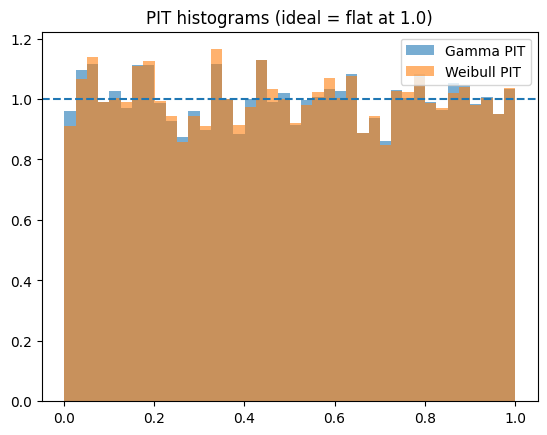

In [32]:
import matplotlib.pyplot as plt

plt.hist(u_gamma, bins=40, density=True, alpha=0.6, label="Gamma PIT")
plt.hist(u_weibull, bins=40, density=True, alpha=0.6, label="Weibull PIT")
plt.axhline(1.0, linestyle="--")
plt.legend(); plt.title("PIT histograms (ideal = flat at 1.0)")
plt.show()

In [69]:
import numpy as np
import pytensor.tensor as pt

# 1) common data: inter-arrival intervals (one obs per event)
times = np.asarray(times_data, float)
dt    = np.empty_like(times)
dt[0] = times[0]
dt[1:] = np.diff(times)
N = len(dt)

coords = {"interval": np.arange(N)}

In [70]:


with pm.Model(coords=coords) as pois_m:
    dt_c = pm.Data("dt", dt, dims=["interval"])
    mu   = pm.HalfNormal("mu", sigma=1.0)

    lam  = pm.math.clip(mu, 1e-12, 1e12)
    ll_i = pm.Deterministic("ll_interval", pm.math.log(lam) - lam * dt_c, dims=["interval"])
    pm.Potential("sum_ll", ll_i.sum())

    id_pois = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True)
    id_pois.add_groups({"log_likelihood": {"interval": id_pois.posterior["ll_interval"]}})


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [54]:
# Build design matrix (N x 6). Make sure each vector has length N == len(dt)
X = np.column_stack([
    np.asarray(x_diff,  float),
    np.asarray(x_tx,    float),
    np.asarray(x_size,  float),
    np.asarray(x_weight,float),
    np.asarray(x_input, float),
    np.asarray(x_fees,  float),
])

In [55]:
col_medians = np.nanmedian(X, axis=0)

In [56]:
X = np.where(np.isfinite(X), X, col_medians)

assert np.all(np.isfinite(X))

In [57]:

feat_names = ["diff","tx","size","weight","input","fees"]

# If your coords already exist, just ensure they include the 'feat' axis:
coords = {
    "interval": np.arange(len(dt)),
    "feat": feat_names,
}

with pm.Model(coords=coords) as ip_m:
    # data
    dt_c = pm.Data("dt", np.asarray(dt, float), dims=["interval"])
    X_c  = pm.Data("X",  X,               dims=["interval", "feat"])

    # priors
    beta0 = pm.Normal("beta0", 0.0, 1.0)          # intercept
    b     = pm.Normal("b", 0.0, 1.0, dims=["feat"])  # slopes for all 6 features

    # intensity and per-interval log-likelihood
    lin   = pm.math.clip(beta0 + (X_c @ b), -40.0, 40.0)  # (N,)
    lam_i = pm.math.exp(lin)
    ll_i  = pm.Deterministic(
        "ll_interval",
        pm.math.log(lam_i) - lam_i * dt_c,
        dims=["interval"]
    )

    # sum of pointwise log-likelihoods is the model likelihood
    pm.Potential("sum_ll", ll_i.sum())

    id_ip = pm.sample(
        1000, tune=1000, chains=2, target_accept=0.9,
        return_inferencedata=True, init="adapt_diag", random_seed=42
    )

# Expose pointwise log-lik for ArviZ (idempotent)
try:
    id_ip.add_groups({"log_likelihood": {"interval": id_ip.posterior["ll_interval"]}})
except ValueError:
    # group exists -> just assign/overwrite the variable
    id_ip.log_likelihood["interval"] = id_ip.posterior["ll_interval"]


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, b]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [58]:
X

array([[-0.9590873 , -0.87962238,  0.92534694,  0.04987307,  2.40490286,
        -0.31182272],
       [-0.9590873 , -0.83694578,  0.85333421,  0.0519989 ,  2.24820673,
        -0.3103471 ],
       [-0.9590873 , -0.3061556 ,  0.07701921,  0.05224437,  0.76584663,
        -0.26484278],
       ...,
       [ 1.56389029,  0.44935355,  0.38512113,  0.05196648, -0.93279828,
        -0.3643057 ],
       [ 1.56389029,  0.31532236,  0.44475686,  0.05200816, -0.43475471,
        -0.28047798],
       [ 1.56389029,  0.89212325,  0.74279921,  0.05141997, -0.02940463,
        -0.32937651]])

In [72]:
from pytensor.tensor.special import gammaln 

# --- 1) Build clean inter-arrivals (seconds) ---
times = np.asarray(times_data, float)               # your event times (seconds), increasing
times = times[np.isfinite(times)]                   # drop any NaNs/Infs just in case
times = np.sort(times)

dt = np.diff(times)                                 # raw gaps
# detect problems
n_nan   = np.sum(~np.isfinite(dt))
n_nonpos= np.sum(~(dt > 0))
print(f"[diag] dt size={dt.size}, NaN/Inf={n_nan}, non-positive={n_nonpos}, "
      f"min={np.nanmin(dt) if dt.size else np.nan}")

# replace any bad gaps by tiny positive epsilon (keeps counts & order)
median_gap = np.nanmedian(dt) if np.isfinite(np.nanmedian(dt)) else 600.0
eps = max(1e-9, 1e-6 * median_gap)                  # ~ micro-fraction of typical gap
dt_fix = np.where(dt > 0, dt, eps)

# --- 2) Scale to ~O(1) for friendly geometry ---
dt_scale = np.median(dt_fix)
dt_s = dt_fix / dt_scale

coords = {"interval": np.arange(dt_s.size)}

# --- 3) Gamma renewal in mean–shape parameterization ---
with pm.Model(coords=coords) as gam_m:
    k = pm.Exponential("k", 1.0)                    # shape > 0, away from 0
    m = pm.LogNormal("m", 0.0, 0.5)                 # mean in *scaled* units (~1)
    rate = pm.Deterministic("rate", k / m)          # PyMC Gamma(alpha=k, beta=rate)

    y = pm.Gamma("y", alpha=k, beta=rate, observed=dt_s, dims=["interval"])

    id_gamma = pm.sample(
        draws=1500, tune=1500, chains=4, target_accept=0.98,
        init="jitter+adapt_diag", return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}, random_seed=42
    )


[diag] dt size=14999, NaN/Inf=0, non-positive=0, min=1.0


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, m]


Output()

Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 22 seconds.


In [73]:
with gam_m:
    # 1) Build a concrete starting point (the “test point”)
    ip = gam_m.initial_point()   # dict of value variables → arrays

    # 2) Check it’s valid (raises if anything is -inf / nan)
    gam_m.check_start_vals(ip)

    # 3) See each term’s logp at the start
    contribs = gam_m.point_logps(point=ip)  # dict: var name -> logp contribution
    print({k: float(v) for k, v in contribs.items()})
    print("total logp:", float(sum(contribs.values())))

    # 4) For a fuller report:
    gam_m.debug()   # prints shapes, transforms, and logp diagnostics

{'k': -1.0, 'm': -0.26, 'y': -20785.35}
total logp: -20786.609999999997
point={'k_log__': array(0.), 'm_log__': array(0.12499998)}

No problems found


In [74]:
with pm.Model(coords=coords) as wei_m:
    alpha = pm.Exponential("alpha", 1.0)       # shape > 0
    scale = pm.LogNormal("scale", 0.0, 0.5)    # scale ~ 1 in scaled units

    y = pm.Weibull("y", alpha=alpha, beta=scale, observed=dt_s, dims=["interval"])

    id_weibull = pm.sample(
        1500, tune=1500, chains=4, target_accept=0.98, init="jitter+adapt_diag",
        return_inferencedata=True, idata_kwargs={"log_likelihood": True}, random_seed=42
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, scale]


Output()

Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 81 seconds.


In [38]:
import pytensor.tensor as pt
from pytensor.scan.basic import scan as pt_scan

def hawkes_ll_interval_vector(times, T, mu, alpha, beta, eps=1e-30):
    """
    Per-event log-likelihood for Hawkes(exp). Length N vector whose sum is the full log-lik on [0,T].
    The last element includes the tail integral (t_N, T].
    """
    # Cast to graph vars / floatX
    times = pt.as_tensor_variable(times).astype(pytensor.config.floatX)
    T     = pt.as_tensor_variable(T).astype(pytensor.config.floatX)
    mu    = pt.as_tensor_variable(mu).astype(pytensor.config.floatX)
    alpha = pt.as_tensor_variable(alpha).astype(pytensor.config.floatX)
    beta  = pt.as_tensor_variable(beta).astype(pytensor.config.floatX)

    # Δt: (t1-0), (t2-t1), ..., (tN - t_{N-1})
    dts = pt.concatenate([times[:1], times[1:] - times[:-1]], axis=0)

    def step(dt, s_post_prev, mu, alpha, beta):
        # state just BEFORE event i
        s_pre  = s_post_prev * pt.exp(-beta * dt)
        lam    = mu + alpha * s_pre
        integ  = mu * dt + (alpha / beta) * (1.0 - pt.exp(-beta * dt)) * s_post_prev
        contrib = pt.log(pt.clip(lam, eps, 1e30)) - integ
        s_post = s_pre + 1.0  # add the new event
        return s_post, contrib

    (s_post_seq, contrib_seq), _ = pt_scan(
        fn=step,
        sequences=[dts],
        outputs_info=[pt.as_tensor_variable(0.0).astype(pytensor.config.floatX), None],
        non_sequences=[mu, alpha, beta],
    )

    # Tail integral (t_N, T]
    tail_dt = pt.maximum(T - times[-1], 0.0)
    tail    = mu * tail_dt + (alpha / beta) * (1.0 - pt.exp(-beta * tail_dt)) * s_post_seq[-1]

    # Put the tail into the last element so sum(contrib_seq) is the joint log-lik
    contrib_seq = pt.concatenate([contrib_seq[:-1], contrib_seq[-1:] - tail], axis=0)
    return contrib_seq

In [39]:
import pytensor
import pytensor.tensor as pt

import pymc as pm

# Ensure these are in consistent units and strictly increasing
times_np = np.asarray(times_data, float)
assert np.all(np.diff(times_np) > 0), "times_data must be strictly increasing"
T_obs_np = float(T_obs)

coords = {"interval": np.arange(times_np.size)}

with pm.Model(coords=coords) as hawkes_m:
    times_c = pm.Data("times", times_np, dims=["interval"])
    T_c     = pm.Data("T",     np.array(T_obs_np, dtype=times_np.dtype))

    mu    = pm.HalfNormal("mu", 1.0)
    beta  = pm.HalfNormal("beta", 1.0)
    rho   = pm.Beta("rho", 2, 5)
    alpha = pm.Deterministic("alpha", rho * beta)

    # Optional stationarity soft-constraint
    pm.Potential("stability", pm.math.switch(alpha / beta < 0.98, 0.0, -np.inf))

    ll_i = hawkes_ll_interval_vector(times_c, T_c, mu, alpha, beta)
    pm.Deterministic("ll_interval", ll_i, dims=["interval"])
    pm.Potential("sum_ll", ll_i.sum())

    id_hawkes = pm.sample(
        200, tune=200, chains=2, target_accept=0.9, init="adapt_diag",
        return_inferencedata=True, random_seed=123
    )

# Register pointwise loglik for ArviZ
id_hawkes.add_groups({"log_likelihood": {"interval": id_hawkes.posterior["ll_interval"]}})

Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, beta, rho]


Output()

Sampling 2 chains for 200 tune and 200 draw iterations (400 + 400 draws total) took 6168 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [62]:
import xarray as xr

def ensure_ll_varname(idata, target="interval", source=None):
    """
    Ensure idata.log_likelihood[target] exists and has dims ('chain','draw','interval').
    If `source` is None, tries 'y' (for Gamma/Weibull) then 'll_interval' (posterior deterministic).
    """
    # Already there
    if hasattr(idata, "log_likelihood") and target in idata.log_likelihood.data_vars:
        return idata

    # pick a source
    if source is None:
        if hasattr(idata, "log_likelihood") and "y" in idata.log_likelihood.data_vars:
            source = ("log_likelihood", "y")          # Gamma/Weibull
        elif hasattr(idata, "posterior") and "ll_interval" in idata.posterior.data_vars:
            source = ("posterior", "ll_interval")     # custom models
        else:
            raise ValueError("No suitable source loglik ('y' or 'll_interval') found.")

    grp, var = source

    # get the DataArray
    if grp == "log_likelihood":
        ll = idata.log_likelihood[var]
    elif grp == "posterior":
        ll = idata.posterior[var]
    else:
        raise ValueError(f"Unknown group {grp}")

    # Make sure dims are ('chain','draw','interval') and the event dim is named 'interval'
    dims = list(ll.dims)
    if {"chain","draw"}.issubset(dims):
        # find the non chain/draw dim
        rest = [d for d in dims if d not in ("chain","draw")]
        if len(rest) != 1:
            raise ValueError(f"Ambiguous event dims for loglik: {dims}")
        evdim = rest[0]
        if evdim != "interval":
            ll = ll.rename({evdim: "interval"})
        ll = ll.transpose("chain","draw","interval")
    else:
        # If someone saved pointwise ll without chain/draw, expand using posterior sizes
        n_chain = idata.posterior.dims.get("chain", None)
        n_draw  = idata.posterior.dims.get("draw",  None)
        if n_chain is None or n_draw is None:
            raise ValueError("Cannot infer chain/draw sizes to expand loglik.")
        if "interval" not in ll.dims:
            # assume it's 1D and rename its only dim to 'interval'
            if ll.ndim != 1:
                raise ValueError(f"Unexpected loglik dims: {ll.dims}")
            ll = ll.rename({ll.dims[0]: "interval"})
        ll = ll.expand_dims(chain=n_chain, draw=n_draw).transpose("chain","draw","interval")

    # Write into group (create group if needed)
    if hasattr(idata, "log_likelihood"):
        idata.log_likelihood[target] = ll
    else:
        idata.add_groups({"log_likelihood": xr.Dataset({target: ll})})
    return idata



In [59]:
id_pois   = ensure_ll_varname(id_pois)                     # expects posterior['ll_interval'] or log_lik['y']
id_ip     = ensure_ll_varname(id_ip)
id_hawkes = ensure_ll_varname(id_hawkes)
id_gamma  = ensure_ll_varname(id_gamma,  source=("log_likelihood","y"))
id_weib   = ensure_ll_varname(id_weib,   source=("log_likelihood","y"))

NameError: name 'ensure_ll_varname' is not defined

In [64]:
def check(idata, name):
    ll = idata.log_likelihood["interval"]
    print(name, ll.dims, ll.shape)

for nm, idt in [("pois", id_pois), ("ip", id_ip), ("hawkes", id_hawkes),
                ("gamma", id_gamma), ("weibull", id_weib)]:
    check(idt, nm)

pois ('chain', 'draw', 'interval_dim_0') (2, 1000, 15000)
ip ('chain', 'draw', 'interval_dim_0') (2, 1000, 15000)
hawkes ('chain', 'draw', 'interval_dim_0') (2, 200, 15000)
gamma ('chain', 'draw', 'interval') (4, 1500, 14999)
weibull ('chain', 'draw', 'interval_dim_0') (2, 1000, 15000)


In [65]:
cmp = az.compare(
    {"poisson": id_pois, "ip": id_ip, "gamma": id_gamma, "weibull": id_weib, "hawkes": id_hawkes},
    ic="loo", method="stacking", var_name="interval"
)
cmp

ValueError: The number of observations should be the same across all models

In [16]:
def make_intervals(times_data):
    t = np.asarray(times_data, float)
    t = t[np.isfinite(t)]
    t = np.sort(t)
    if t.size == 0:
        raise ValueError("No events")

    # gaps: from 0→t0, then between events
    dt = np.empty_like(t)
    dt[0]  = t[0]                 # gap from 0 to first event
    di     = np.diff(t)
    # robust tiny epsilon to avoid zeros/negatives everywhere
    med    = np.median(di[di>0]) if np.any(di>0) else max(t[0], 600.0)
    eps    = max(1e-12, 1e-9*med)
    dt[1:] = np.where(di > 0, di, eps)
    # clip the first gap too (in case t[0]==0)
    dt[0]  = max(dt[0], eps)

    return t, dt, eps

times, dt, eps = make_intervals(times_data)   # <-- use your times_data here
N = dt.size
coords = {"interval": np.arange(N)}

In [17]:
with pm.Model(coords=coords) as pois_m:
    dt_c = pm.Data("dt", dt, dims=["interval"])
    mu   = pm.HalfNormal("mu", 1.0)
    lam  = pm.math.clip(mu, 1e-12, 1e12)
    ll_i = pm.math.log(lam) - lam * dt_c
    pm.Deterministic("ll_interval", ll_i, dims=["interval"])
    pm.Potential("sum_ll", ll_i.sum())
    id_pois = pm.sample(1000, tune=1000, chains=2, target_accept=0.9,
                        return_inferencedata=True, init="adapt_diag", random_seed=42)

# expose pointwise loglik for ArviZ
id_pois.add_groups({"log_likelihood": {"interval": id_pois.posterior["ll_interval"]}})


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [1]:
with pm.Model(coords=coords) as ip_m:
    dt_c   = pm.Data("dt", dt, dims=["interval"])
    xdiff  = pm.Data("x_diff", x_diff, dims=["interval"])
    xtx    = pm.Data("x_tx",   x_tx,   dims=["interval"])

    beta0  = pm.Normal("beta0", 0, 2)
    b_diff = pm.Normal("b_diff", 0, 1)
    b_tx   = pm.Normal("b_tx",   0, 1)

    lin  = beta0 + b_diff*xdiff + b_tx*xtx
    lin  = pm.math.clip(lin, -20, 20)             # numeric safety
    lam  = pm.math.exp(lin)

    ll_i = pm.math.log(lam) - lam * dt_c
    pm.Deterministic("ll_interval", ll_i, dims=["interval"])
    pm.Potential("sum_ll", ll_i.sum())
    id_ip = pm.sample(1000, tune=1000, chains=2, target_accept=0.9,
                      return_inferencedata=True, init="adapt_diag", random_seed=42)

    id_ip.add_groups({"log_likelihood": {"interval": id_ip.posterior["ll_interval"]}})

NameError: name 'pm' is not defined

In [19]:
with pm.Model(coords=coords) as weib_m:
    k     = pm.Exponential("k", 1.0)        # shape > 0
    scale = pm.Exponential("scale", 1.0)    # scale > 0
    y     = pm.Weibull("y", alpha=k, beta=scale, observed=dt, dims=["interval"])
    id_weib = pm.sample(1000, tune=1000, chains=2, target_accept=0.95,
                        return_inferencedata=True, init="adapt_diag",idata_kwargs={"log_likelihood": True}, random_seed=42)

id_weib.log_likelihood["interval"] = id_weib.log_likelihood["y"]

Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, scale]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [20]:
with pm.Model(coords=coords) as gam_m:
    # use built-in likelihood so ArviZ records ll per obs automatically
    k    = pm.Exponential("k", 1.0)         # shape > 0
    rate = pm.Exponential("rate", 1.0)      # rate > 0  (1/scale)
    y    = pm.Gamma("y", alpha=k, beta=rate, observed=dt, dims=["interval"])
    id_gamma = pm.sample(1000, tune=1000, chains=2, target_accept=0.95,
                         return_inferencedata=True, init="adapt_diag", idata_kwargs={"log_likelihood": True}, random_seed=42)

# alias to a common name
id_gamma.log_likelihood["interval"] = id_gamma.log_likelihood["y"]

Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, rate]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [21]:
with pm.Model(coords=coords) as weib_m:
    k     = pm.Exponential("k", 1.0)        # shape > 0
    scale = pm.Exponential("scale", 1.0)    # scale > 0
    y     = pm.Weibull("y", alpha=k, beta=scale, observed=dt, dims=["interval"])
    id_weib = pm.sample(1000, tune=1000, chains=2, target_accept=0.95,
                        return_inferencedata=True, init="adapt_diag", idata_kwargs={"log_likelihood": True}, random_seed=42)

id_weib.log_likelihood["interval"] = id_weib.log_likelihood["y"]

Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, scale]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [26]:
import pytensor.tensor as pt
from pytensor.scan.basic import scan

def hawkes_ll_interval_pt(dt, mu, alpha, beta, eps=1e-12):
    dt = pt.as_tensor_variable(dt)
    mu    = pt.clip(mu, eps, 1e12)
    alpha = pt.clip(alpha, eps, 1e12)
    beta  = pt.clip(beta, eps, 1e12)

    def step(dti, s_prev, mu, alpha, beta):
        s_i   = pt.exp(-beta*dti) * (s_prev + 1.0)
        lam_i = mu + alpha*s_i
        log_term = pt.log(pt.clip(lam_i, eps, 1e12))
        integ    = mu*dti + (alpha/beta) * s_prev * (1.0 - pt.exp(-beta*dti))
        return s_i, (log_term - integ)

    (s_seq, contrib_seq), _ = scan(
        fn=step,
        sequences=[dt],
        outputs_info=[pt.as_tensor_variable(0.0).astype(dt.dtype), None],
        non_sequences=[mu, alpha, beta],
    )
    return contrib_seq

with pm.Model(coords=coords) as hawkes_m:
    dt_c  = pm.Data("dt", dt, dims=["interval"])
    mu    = pm.HalfNormal("mu", 1.0)
    beta  = pm.HalfNormal("beta", 1.0)
    rho   = pm.Beta("rho", 2, 5)
    alpha = pm.Deterministic("alpha", rho*beta)

    # optional soft stationarity constraint (alpha/beta < 1)
    pm.Potential("stability", pm.math.switch(alpha/beta < 0.98, 0.0, -np.inf))

    ll_i = hawkes_ll_interval_pt(dt_c, mu, alpha, beta)
    pm.Deterministic("ll_interval", ll_i, dims=["interval"])
    pm.Potential("sum_ll", ll_i.sum())

    # Use Metropolis for robustness (no gradients through scan)
    id_hawkes = pm.sample(1000, tune=1000, chains=2, step=pm.Metropolis(),
                          return_inferencedata=True, init="adapt_diag",idata_kwargs={"log_likelihood": True}, random_seed=42)

#id_hawkes.log_likelihood["interval"] = id_hawkes.posterior["ll_interval"]
id_hawkes.add_groups({"log_likelihood": {"interval": id_hawkes.posterior["ll_interval"]}})

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [beta]
>Metropolis: [rho]


Output()

/home/phumz/miniconda3/envs/bayes310/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 594 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [60]:
def show_shape(name, idata):
    ll = idata.log_likelihood["interval"]
    print(name, ll.dims, ll.shape)

for nm, idt in [("pois", id_pois), ("ip", id_ip), ("gamma", id_gamma),
                ("weibull", id_weib), ("hawkes", id_hawkes)]:
    show_shape(nm, idt)

pois ('chain', 'draw', 'interval_dim_0') (2, 1000, 15000)
ip ('chain', 'draw', 'interval_dim_0') (2, 1000, 15000)
gamma ('chain', 'draw', 'interval') (2, 1000, 15000)
weibull ('chain', 'draw', 'interval') (2, 1000, 15000)
hawkes ('chain', 'draw', 'interval_dim_0') (2, 1000, 15000)


In [61]:
import arviz as az
cmp = az.compare(
    {"poisson": id_pois, "ip": id_ip, "gamma": id_gamma, "weibull": id_weib, "hawkes": id_hawkes},
    ic="loo", method="stacking", var_name="interval"
)
cmp

/home/phumz/miniconda3/envs/bayes310/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hawkes,0,-104990.806061,1.359907,0.000000,1.000000e+00,152.940672,0.000000,False,log
ip,1,-109544.113737,17.676066,4553.307676,2.234954e-07,127.754971,80.865807,True,log
gamma,2,-110509.046199,2.075028,5518.240138,9.380840e-08,120.070543,72.432015,False,log
poisson,3,-110520.008073,0.990718,5529.202012,7.217620e-09,119.890321,68.901712,False,log
weibull,4,-110522.457509,1.865062,5531.651447,0.000000e+00,124.495873,70.110131,False,log
